 # Imports Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from datetime import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
# import modin.pandas as pd
# import modin
import pandas as pd
from scipy.optimize import minimize 
from utils import *
from importlib import reload
from collections import defaultdict

import matplotlib.font_manager as fm

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Raleway'
plt.rcParams['font.style'] = "normal"
# plt.rcParams['font.weight'] = 'Light'
# plt.rcParams['font.serif'] = 'Times New Roman'
# plt.rcParams['font.size'] = 12
# font.cursive
# font.family
# font.fantasy
# font.monospace
# font.sans-serif
# font.serif
# font.size
# font.stretch
# font.style
# font.variant
# font.weight
# legend.fontsize
# legend.title_fontsize
# mathtext.fontset
# pdf.fonttype
# pdf.use14corefonts
# pgf.rcfonts
# ps.fonttype
# svg.fonttype

# plot_trading_rule(dfXcpi, dfrtn, xcol=xcol, rtn_col=rtn_col, 
#                   weights=weights, save_plot=True, show_plot=True)

# for k in plt.rcParams.keys():
#     if "font" in k:
#         print(k)

In [5]:
import strategies
from strategies import calc_excess_returns, factor_barplot, portfolio_performance, negative_sharpe_ratio, optimize_portfolio, calculate_factor_exposures, calculate_factor_exposures2, calc_strat_returns

In [6]:
dfcpi_fred = pd.read_parquet("workspace/cpi_fred_factors.pq").reset_index()

In [7]:
df_all = pd.read_parquet("workspace/dfreturns_with_factors.pq")


factor_cols = ['date', 'refmonthyear', 'cpi.hml', 'pmi.hml', 'nmi.hml', 
                '3M_rising', '6M_rising', '9M_rising', '12M_rising']


cpi_factors = ['date', 'refmonthyear', 
               '3M_rising', '6M_rising', '9M_rising', '12M_rising',
               '3M_rising_yoy', '6M_rising_yoy', '9M_rising_yoy', '12M_rising_yoy']

rtn_cols = [c for c in df_all.columns if c.startswith('rtn') & c.endswith("M")]
tickers = list(df_all['ticker'].unique())

# Need to unstack returns per sector to split factor columns
dfrtn = df_all.pivot(columns="ticker", index=['date', 'refmonthyear'], values=rtn_cols)
head(dfrtn)

dfX = df_all[factor_cols].copy().drop_duplicates()
dfX.set_index(['date', 'refmonthyear'], inplace=True)



dfXcpi = dfcpi_fred[cpi_factors].copy().drop_duplicates()
dfXcpi.set_index(['date', 'refmonthyear'], inplace=True)

fwd_returns = {}

df2 = dfrtn.stack(future_stack=True)
df2.reset_index(inplace=True)

for ticker in tickers:
    fwd_returns[ticker] = df2[df2['ticker'] == ticker].copy()

del df2

datemap = df_all[['refmonthyear', 'date']].drop_duplicates().copy()
datemap['date'] = datemap['date'].apply(lambda x: pd.to_datetime(x).date())

In [8]:
df_all.head()

,refmonthyear,ticker,date,nmi.hml,pmi.hml,cpi.hml,rtn,rtn_date,3M_rising,6M_rising,...,rtn_3M,rtn_4M,rtn_5M,rtn_6M,rtn_7M,rtn_8M,rtn_9M,rtn_10M,rtn_11M,rtn_12M
0,OCT.1989,s5cond,1989-10-31,NaN,LOW,HIGH,-0.048166,1989-10-31,True,True,...,-0.008771,-0.024954,-0.018526,-0.007617,-0.012665,-0.005347,-0.001097,-0.008358,-0.004850,-0.011541
1,NOV.1989,s5cond,1989-11-30,NaN,LOW,HIGH,-0.006986,1989-11-30,True,True,...,0.006305,0.003513,0.001732,0.002848,-0.001024,-0.002621,-0.000951,-0.008429,-0.011657,-0.031212
2,DEC.1989,s5cond,1989-12-29,NaN,LOW,HIGH,-0.006937,1989-12-29,True,True,...,0.023684,0.016164,0.018037,0.004831,-0.003538,-0.001609,-0.028990,-0.039751,-0.027297,-0.036295
3,JAN.1990,s5cond,1990-01-31,NaN,LOW,HIGH,-0.065070,1990-01-31,True,True,...,0.008001,0.000479,0.018618,0.013383,0.018979,0.009627,0.012117,0.015704,0.023048,0.013475
4,FEB.1990,s5cond,1990-02-28,NaN,MED,HIGH,0.022914,1990-02-28,True,True,...,0.014754,0.028664,0.023865,0.038500,0.035881,0.039468,0.035832,0.038875,0.040424,0.049318


In [384]:
dfcpi_tleaf = pd.read_parquet("workspace/cpi_turnleaf_factors.pq").reset_index()
dfcpi_tleaf['date'] = dfcpi_tleaf['refdate'].apply(lambda x: pd.to_datetime(x).date())

# Create rolling factors

In [116]:
def rolling_factor_means(df, datemap=None, factor='6M_rising_yoy', rtn_col='rtn_1M', lookback=24, min_periods=None): 
    
    if datemap is None:
        datemap = df[['refmonthyear', 'date']].drop_duplicates().copy()
        datemap['date'] = datemap['date'].apply(lambda x: pd.to_datetime(x).date())
    
    if min_periods is None:
        min_periods=lookback
    result = (df.groupby(['ticker', factor])
              .rolling(lookback, on='refmonthyear', min_periods=min_periods)[rtn_col]
              .mean()
              ).reset_index()
    
    result = result.join(datemap.set_index('refmonthyear'), on='refmonthyear')
    return result


In [53]:
fred_cpi_factors = dfcpi_fred[['refmonthyear'] + [c for c in dfcpi_fred.columns if (c.endswith('_rising_yoy') )]]

In [42]:
refperiods = df_all['refmonthyear'].unique()

In [58]:
df_all = pd.merge(df_all, fred_cpi_factors, on='refmonthyear', how='inner')
df_all['date'] = df_all['date'].apply(lambda x: pd.to_datetime(x).date())

In [9]:
dftl = pd.read_parquet("workspace/dfreturns_with_tlfactors.pq")
tleaf_factor_cols = (['date', 'refdate', 'refmonthyear'] + 
                     [c for c in dfcpi_tleaf.columns if c.endswith('_rising_yoy')])
dftlX = dfcpi_tleaf[tleaf_factor_cols].copy()

NameError: name 'dfcpi_tleaf' is not defined

In [43]:
# for each ref period, get prior N years of data, and calculate mean return per sector per factor
# 3M_rising         6M_rising[
# 9M_rising         12M_rising
# 3M_rising_yoy     6M_rising_yoy
# 9M_rising_yoy     12M_rising_yoy

In [78]:
rolling_results = {}

In [73]:
nperiods = [12, 24, 36, 48, 60]
factors = ['3M_rising_yoy', '6M_rising_yoy', '9M_rising_yoy', '12M_rising_yoy']
rtn_cols = ['rtn_1M', 'rtn_2M', 'rtn_3M', 'rtn_6M']
for nper in nperiods:
    for factor in factors:
        for rtn_col in rtn_cols:
            # nper = 12
            # factor = '6M_rising_yoy'
            # rtn_col = 'rtn_1M'
            print(f"Generating rolling factors for {factor} and {rtn_col} with {nper} period window")
            key = f"{factor}.{rtn_col}.window{nper}"            
            df = rolling_factor_means(df_all, factor=factor, rtn_col=rtn_col, lookback=nper)

            rolling_results[key] = df


In [169]:
lookback=24
factor = '6M_rising_yoy'
rtn_col = 'rtn_1M'

df = (df_all.groupby(['ticker', factor])
              .rolling(lookback, on='refmonthyear', min_periods=lookback)[rtn_col]
              .mean()
              ).reset_index()
df = df.join(datemap.set_index('refmonthyear'), on='refmonthyear')
df = df[['date', 'refmonthyear', 'ticker', factor, rtn_col]]

# Evaluate Rolling Factors Returns

In [223]:
def get_weight(ticker, sigval, weights):
    if sigval is None:
        return 0
    return weights[sigval][ticker]
    
def zero():
    return 0

In [222]:
def apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights):
    tickers = dfrtn[rtn_col].columns.values
    
    # strat_code = f"totrtn.{xcol}.{rtn_col}"
    
    dfjoint = pd.merge(dfrtn[rtn_col].reset_index(), 
                       dfX[xcol].reset_index(), 
                       left_on='refmonthyear', 
                       right_on='refmonthyear', 
                       suffixes=('', '_y'),
                       how='inner').dropna()
    dfjoint = dfjoint[dfjoint[xcol] != None]    
    
    for ticker in tickers:
        wgtcol = f"wgt.{ticker}" 
        wgtrtncol = f"wgtrtn.{ticker}" 
        dfjoint[wgtcol] = dfjoint[xcol].apply(lambda x: get_weight(ticker, x, weights))
        dfjoint[wgtrtncol] = dfjoint[wgtcol] * dfjoint[ticker]
    
    wgtreturns = dfjoint[[c for c in dfjoint.columns if c.startswith('wgtrtn')]].copy()
    # wgtreturns[strat_code] = np.cumprod(wgtreturns.agg(func='sum', axis='columns').apply(lambda x: 1+x)) * 100
    wgtreturns['totrtn'] = np.cumprod(wgtreturns.agg(func='sum', axis='columns').apply(lambda x: 1+x)) * 100
    wgtreturns = pd.DataFrame(wgtreturns['totrtn']).reset_index()
    wgtreturns['date'] = dfjoint['date'].copy()
    wgtreturns['refmonthyear'] = dfjoint['refmonthyear'].copy()
    wgtreturns = wgtreturns.sort_values('date')
    # wgtreturns.set_index('date', inplace=True)
    return wgtreturns


def plot_trading_rule(dfX, dfrtn, xcol, rtn_col, weights, 
                      save_plot=True, show_plot=False, title=None,
                     xlabel=None, ylabel=None):
    if title is None:
        title = f"totrtn.{xcol}.{rtn_col}"
    strat_return = apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights=weights)
    
    mktweights = defaultdict(zero)
    spxlong = defaultdict(zero)
    spxlong['spx'] = 1
    mktweights[True] = spxlong
    mktweights[False] = spxlong
    mkt_return = apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights=mktweights)
    if not show_plot:
        plt.ioff()


    plt.figure(figsize=(10, 4))
    
    plt.plot(strat_return['date'], strat_return['totrtn'], label='Long/Short');
    plt.plot(mkt_return['date'], mkt_return['totrtn'], label='SPX');
    plt.title(title);
    plt.legend();
    plt.grid(ls='--', alpha=.5);

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    
    if save_plot:
        figname = f"img/trading_rule_plots/{title}.png"
        plt.savefig(figname, dpi=200)

    if show_plot:
        plt.show()

    plt.close()
    plt.ion()

In [257]:
def make_weight_vector(tickers, default_weight=0.0):
    weights = {}    
    for t in tickers:
        weights[t] = default_weight
    
    weights = pd.Series(weights, name='weight')
    return weights

In [477]:
def get_longs_shorts(df, factor='6M_rising_yoy', rtn_col='rtn_1M', lookback=24):
    unique_dates = [d for d in df['date'].unique()]
    unique_refmonthyear = [d for d in df['refmonthyear'].unique()]
    
    start_dt = unique_dates[0]
    end_dt = unique_dates[lookback-1]
    df_prior = df[df['date'] <= start_dt].copy()
    
    start_index = lookback
    
    tickers = df['ticker'].unique()
    
    longs_shorts = []
    
    
    for i in range(start_index, len(unique_dates)):
        start_dt = unique_dates[i-lookback]
        end_dt = unique_dates[i-1]   
        trade_dt = unique_dates[i]
        df_prior = df[(df['date'] >= start_dt) & (df['date'] <= end_dt)].copy()
        df_prior = df_prior[df_prior[factor].isna() == False]
        mean_returns = df_prior.groupby(['ticker', factor], observed=True)[rtn_col].agg('mean')
        excess_returns = mean_returns - mean_returns['spx']
        excess_returns = excess_returns.reset_index()
        
        ls = {}
        longs_rising = defaultdict(zero)
        shorts_rising = defaultdict(zero)
        longs_falling = defaultdict(zero)
        shorts_falling = defaultdict(zero)
        
        rising_weights = make_weight_vector(tickers, default_weight=0.0)
        falling_weights = make_weight_vector(tickers, default_weight=0.0)
        # is_rising = df[df['']]
        is_rising = df.iloc[i][factor] == True
        # is_rising = dftl[dftl['refmonthyear'] == df.iloc[i]['refmonthyear']][factor].values[0] == True
        
        
        for ticker in excess_returns[excess_returns[factor]==True].sort_values(rtn_col, ascending=False).head(2)['ticker'].values:
                # longs_rising[ticker] = 1.0
            rising_weights[ticker] = 1.0
 
        for ticker in excess_returns[excess_returns[factor]==True].sort_values(rtn_col, ascending=True).head(2)['ticker'].values:
                # shorts_rising[ticker] = -1.0
            rising_weights[ticker] = -1.0

        for ticker in excess_returns[excess_returns[factor]==False].sort_values(rtn_col, ascending=False).head(2)['ticker'].values:
                # longs_falling[ticker] = 1.0
            falling_weights[ticker] = 1.0
            
        for ticker in excess_returns[excess_returns[factor]==False].sort_values(rtn_col, ascending=True).head(2)['ticker'].values:
                # shorts_falling[ticker] = -1.0
            falling_weights[ticker] = -1.0
        
        longs_shorts.append((trade_dt, factor, rtn_col, is_rising, rising_weights, falling_weights))
        # ls['rising'] = {'longs': longs_rising, 'shorts': shorts_rising}
        # ls['falling'] = {'longs': longs_falling, 'shorts': shorts_falling} 
        # 
        # longs_shorts[trade_dt] = ls
    
    return longs_shorts

def calc_ls_returns(trade_weights, dfrtns, dfsignal, sigcol, rtn_col='rtn_1M'):
    returns = []
    mktreturns = []
    dates = []
    signal_values = []
    start_dt = dfsignal['date'].min()
    for trade in trade_weights:
        date = trade[0]
        if date < start_dt:
            continue
        is_rising = dfsignal[dfsignal['date'] == date][sigcol].values[0]
        if is_rising:
            weights = trade[2]
        else:
            weights = trade[3]
        
        # returns.append(dfrtns[dfrtns['date'] == date][rtn_col][tickers] @ weights)
        returns.append(dfrtns[dfrtns['date'] == date][rtn_col][tickers] @ weights)
        dates.append(date)
        signal_values.append(is_rising)
        mktreturns.append(dfrtns[dfrtns['date'] == date][rtn_col]['spx'].values[0])
        
    dates = np.array(dates).flatten()
    returns = np.array(returns).flatten()
    mktreturns = np.array(mktreturns).flatten()
    signal_values = np.array(signal_values).flatten()
    totrtn = np.cumprod(returns + 1.0) * 100
    mkttotrtn = np.cumprod(mktreturns + 1.0) * 100
    df = pd.DataFrame({'date': dates, 'signal': signal_values, 'return': returns, 'totrtn': totrtn.flatten()})
    df['spx_return'] = mktreturns.flatten()
    df['spx_totrtn'] = mkttotrtn.flatten()
    df = pd.DataFrame['signal'] = sigcol
    return df

In [264]:
tickers = df_all['ticker'].unique()
dfrtn.reset_index(inplace=True)
dfrtn['date'] = dfrtn['date'].apply(lambda x: pd.to_datetime(x).date())

In [426]:
lookback = 84
rtn_col = 'rtn_1M'
factor = '6M_rising_yoy'

trades3m = get_longs_shorts(df_all, factor='3M_rising_yoy', rtn_col=rtn_col, lookback=lookback)
trades6m = get_longs_shorts(df_all, factor='6M_rising_yoy', rtn_col=rtn_col, lookback=lookback)
trades9m = get_longs_shorts(df_all, factor='9M_rising_yoy', rtn_col=rtn_col, lookback=lookback)

dftlX = 

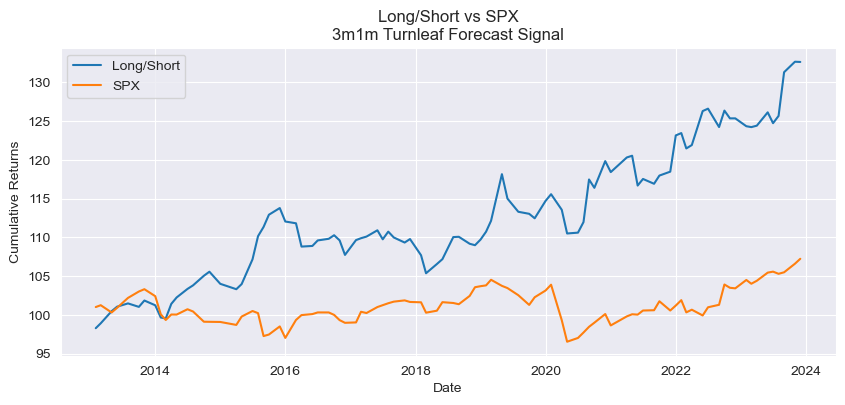

In [459]:
tlfactor = '3m1m_rising_yoy'
rtn_col = 'rtn_1M'
weights_vector = trades3m


dates = []
returns = []
signal_values = []
market_returns = []
for trade in weights_vector:
    date = trade[0]
    if date not in dftlX['date'].values:
        continue
    is_rising = dftlX[dftlX['date'] == date][tlfactor].values[0]
    weights = trade[4] if is_rising else trade[5]
    # weights = trade[2]    
    returns.append(dfrtn[dfrtn['date'] == date][rtn_col][tickers] @ weights)
    dates.append(date)
    signal_values.append(is_rising)
    market_returns.append(dfrtn[dfrtn['date'] == date][rtn_col]['spx'].values[0])

dates = np.array(dates)
returns = np.array(returns)
market_returns = np.array(market_returns)
signal_values = np.array(signal_values)
totrtn = np.cumprod(returns + 1.0) * 100
totrtnmkt = np.cumprod(market_returns + 1.0) * 100


plt.plot(dates, totrtn, label='Long/Short');
plt.plot(dates, totrtnmkt, label='SPX');
# plt.title(f"{rtn_col} fwd returns for {tlfactor}");
plt.title("Long/Short vs SPX\n3m1m Turnleaf Forecast Signal")
plt.ylabel("Cumulative Returns");
plt.xlabel("Date");
plt.legend();

Strategy above is rebalanced monthly, using an 84 month lookback period to determine the best 2 longs and best 2 shorts to use when inflation is rising and when inflation is falling. The returns used to construct total returns are the 1month forward returns for the month following the release of a CPI print. 

In [484]:
df = pd.DataFrame({'date': dates, 
                   'signal': signal_values.flatten(), 
                   'return': returns.flatten(), 
                   'totrtn': totrtn.flatten(),
                   'spx_return': market_returns.flatten(),
                   'spx_totrtn': totrtnmkt.flatten()})
# df['spx_return'] = market_returns
# df['spx_totrtn'] = totrtnmkt
# df = pd.DataFrame['signal'] = tlfactor

In [486]:
df.tail()

,date,signal,return,totrtn,spx_return,spx_totrtn
89,2023-06-30,True,-0.011084,124.744688,0.001221,105.577652
90,2023-07-31,False,0.007496,125.679732,-0.002641,105.298864
91,2023-08-31,False,0.044917,131.324860,0.001852,105.493826
92,2023-10-31,True,0.010312,132.679095,0.010511,106.602635
93,2023-11-30,False,-0.000222,132.649638,0.005958,107.237824


In [485]:
df.to_clipboard()